In [2]:
import datetime; import time
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import netCDF4 as nc
from Utils.readData  import *
from Utils.filter_query import *
from tqdm import tqdm
from joblib import Parallel, delayed
from scipy.sparse import csr_matrix, coo_matrix, csc_matrix
from scipy import sparse
from scipy.sparse.linalg import inv
import geopy.distance
import pickle

spatial and time domains

In [3]:
### Different grids to use
# Full grid used for footprints
full_xLim = [ -125.0, -120.0 ]
full_yLim = [   36.0,   40.0 ]
big_xLim,big_yLim = full_xLim,full_yLim
# Medium sized grid
medium_xLim = [-123.60,-121.60]
medium_yLim = [  36.80,  38.60]
med_xLim,med_yLim = medium_xLim,medium_yLim
# Bay Area domain (smallest grid)
BayArea_xLim = [-123.10,-121.80]
BayArea_yLim = [  37.35,  38.40]
small_xLim,small_yLim = BayArea_xLim,BayArea_yLim
# Inversion grid to use
Inv_lonLim = small_xLim
Inv_latLim = small_yLim

In [4]:
start_date = datetime.datetime(2018, 1, 4, 0)
end_date = datetime.datetime(2018, 1, 5, 0)
time_domain = [start_date, end_date]

In [5]:
lats = np.linspace(36, 40, 481)
lons = np.linspace(-125, -120, 601)

In [6]:
time_domain

[datetime.datetime(2018, 1, 4, 0, 0), datetime.datetime(2018, 1, 5, 0, 0)]

directories and files

In [7]:
footprint_directory = "/home/disk/hermes/data/footprints/BEACO2N/obs/"
emission_directory = "/home/disk/hermes/data/emissions/BEACO2N/"

In [8]:
footprint_files = get_files(footprint_directory)
emission_files = get_files(emission_directory)
emission_files.sort()
footprint_files.sort()
print(len(footprint_files), len(emission_files))

490646 27049


Get filtered footprints and emissions

In [8]:
emission_df = get_emission_domain_df(emission_files)
foot_df = get_footprint_domain_df(footprint_files)

In [9]:
emission_filtered_files, emission_files_df = filter_emissions(emission_files, time_domain)

In [10]:
foot_filtered_files, foot_files_df = filter_obs(footprint_files, Inv_lonLim, Inv_latLim, agl_domain='')

In [11]:
emission_files_df.head()

,file,time
88,/home/disk/hermes/data/emissions/BEACO2N/BEACO...,2018-01-04 00:00:00
89,/home/disk/hermes/data/emissions/BEACO2N/BEACO...,2018-01-04 01:00:00
90,/home/disk/hermes/data/emissions/BEACO2N/BEACO...,2018-01-04 02:00:00
91,/home/disk/hermes/data/emissions/BEACO2N/BEACO...,2018-01-04 03:00:00
92,/home/disk/hermes/data/emissions/BEACO2N/BEACO...,2018-01-04 04:00:00


In [12]:
foot_files_df.head()

,file,time,lon,lat,agl
0,/home/disk/hermes/data/footprints/BEACO2N/obs/...,2018-01-01 08:00:00,-122.155,37.754,3.0000
1,/home/disk/hermes/data/footprints/BEACO2N/obs/...,2018-01-01 08:00:00,-122.175,37.737,3.0000
2,/home/disk/hermes/data/footprints/BEACO2N/obs/...,2018-01-01 08:00:00,-122.181,37.819,9.0000
3,/home/disk/hermes/data/footprints/BEACO2N/obs/...,2018-01-01 08:00:00,-122.196,37.736,7.8232
4,/home/disk/hermes/data/footprints/BEACO2N/obs/...,2018-01-01 08:00:00,-122.205,37.809,7.0000


In [13]:
def get_previous_emissions(timestamp, ems_file, current_emission, nlats=481, nlons=601, time_window=71, emission_files=emission_files):
    # time_window: hours
    index = emission_files.index(ems_file)
    previous_ems_files = emission_files[max(0, index-time_window):index]
    previous_emissions = np.zeros((time_window+1, nlats, nlons))
    for idx, file in enumerate(previous_ems_files):
        prev_ems = np.array(nc.Dataset(file)['flx_total'])
        previous_emissions[idx, :, :] = prev_ems
    previous_emissions[-1, :, :] = current_emission
    return previous_emissions

Looping over

In [14]:
def case_a_time_integrated_y(H, X, actual_y):
    # X are emissions of given time only
    H_compressed = np.nansum(np.array(H), axis=0)
    # X = np.nansum(X, axis=0)/X.shape[0]
    y_pred = np.sum(np.multiply(H_compressed, X))
    # y_pred2 = np.matmul(H_compressed.reshape(1, -1), X.reshape(-1, 1))
    return y_pred
    # print(y_pred, actual_y)

In [15]:
def case_b_time_resolved_y(H, X, actual_y):
    y_pred = np.sum(np.multiply(H, X))
    # y_pred2 = 0
    # for i in range(H.shape[0]):
    #     y_pred2 += np.sum(np.multiply(H[i,:,:], X[i,:,:]))
    return y_pred
    # print(y_pred, actual_y)

In [16]:
def get_predictions_y(ems_file):
    final_list = []
    # for ems_file in tqdm(emission_filtered_files[8:]):
    trimmed_file = ems_file.split("/")[-1].replace("_", "x")
    [_, year, month, day, hour] = trimmed_file.replace('.ncdf', '').split("x")
    year = int(year)
    month = int(month)
    day = int(day)
    hour = int(hour)
    timestamp = datetime.datetime(year, month, day, hour)
    ems_data = nc.Dataset(ems_file)
    current_emissions = np.array(ems_data['flx_total'])
    previous_emissions = get_previous_emissions(timestamp, ems_file, current_emissions)
    # print(timestamp)
    # Footprints
    foot_files_single_time = list(foot_files_df[foot_files_df['time']==timestamp]['file'])
    for foot_file in foot_files_single_time:
        foot_data = nc.Dataset(foot_file)
        yi = np.array(foot_data['co2'])[0] - np.array(foot_data['bkg_co2_NOAA'])[0]
        hi = np.array(foot_data['foot'])
        casea = case_a_time_integrated_y(hi, current_emissions, yi)
        if hi.shape[0] != previous_emissions.shape[0]:
            if hi.shape[0] < previous_emissions.shape[0]:
                previous_emission = previous_emissions[-hi.shape[0]:,:,:]
                caseb = case_b_time_resolved_y(hi, previous_emission, yi)
                previous_emission = np.nansum(previous_emission, axis=0)/previous_emission.shape[0]
                casec = case_a_time_integrated_y(hi, previous_emission, yi)
        else:
            caseb = case_b_time_resolved_y(hi, previous_emissions, yi)
            previous_emission = np.nansum(previous_emissions, axis=0)/previous_emissions.shape[0]
            casec = case_a_time_integrated_y(hi, previous_emission, yi)
        final_list.append([foot_file, ems_file, casea, caseb, casec, yi])
    return final_list

In [17]:
def main():
    OUTPUT = Parallel(n_jobs=-1, verbose=0, backend='multiprocessing')(delayed(get_predictions_y)(ems_file) for ems_file in tqdm(emission_filtered_files))
    final_result = []
    for idx, val in enumerate(OUTPUT):
        final_result += val
    return pd.DataFrame(final_result, columns=['foot_file', 'ems_file', 'time_integrated_current_ems', 'time_resolved', 'time_integrated_average_ems', 'actual_observation'])

In [ ]:
results_df = main()

In [ ]:
results_df.head()

Visualization

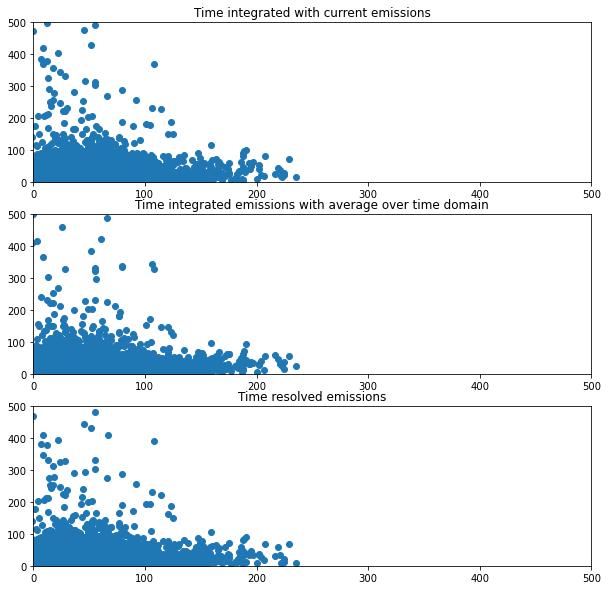

In [20]:
fig, axs = plt.subplots(3, 1, figsize=(10,10))
axs[0].scatter(results_df['actual_observation'], results_df['time_integrated_current_ems'], cmap='pink')
axs[0].set_title("Time integrated with current emissions")
axs[0].set_xlim(0, 500)
axs[0].set_ylim(0, 500)
axs[1].scatter(results_df['actual_observation'], results_df['time_integrated_average_ems'])
axs[1].set_title("Time integrated emissions with average over time domain")
axs[1].set_xlim(0, 500)
axs[1].set_ylim(0, 500)
axs[2].scatter(results_df['actual_observation'], results_df['time_resolved'])
axs[2].set_title("Time resolved emissions")
axs[2].set_xlim(0, 500)
axs[2].set_ylim(0, 500)
plt.show()

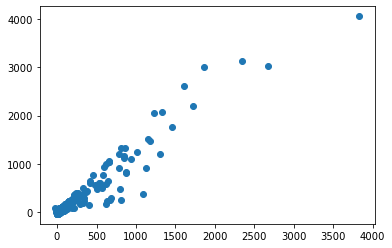

In [21]:
plt.scatter(results_df['time_integrated_average_ems'], results_df['time_integrated_current_ems'])

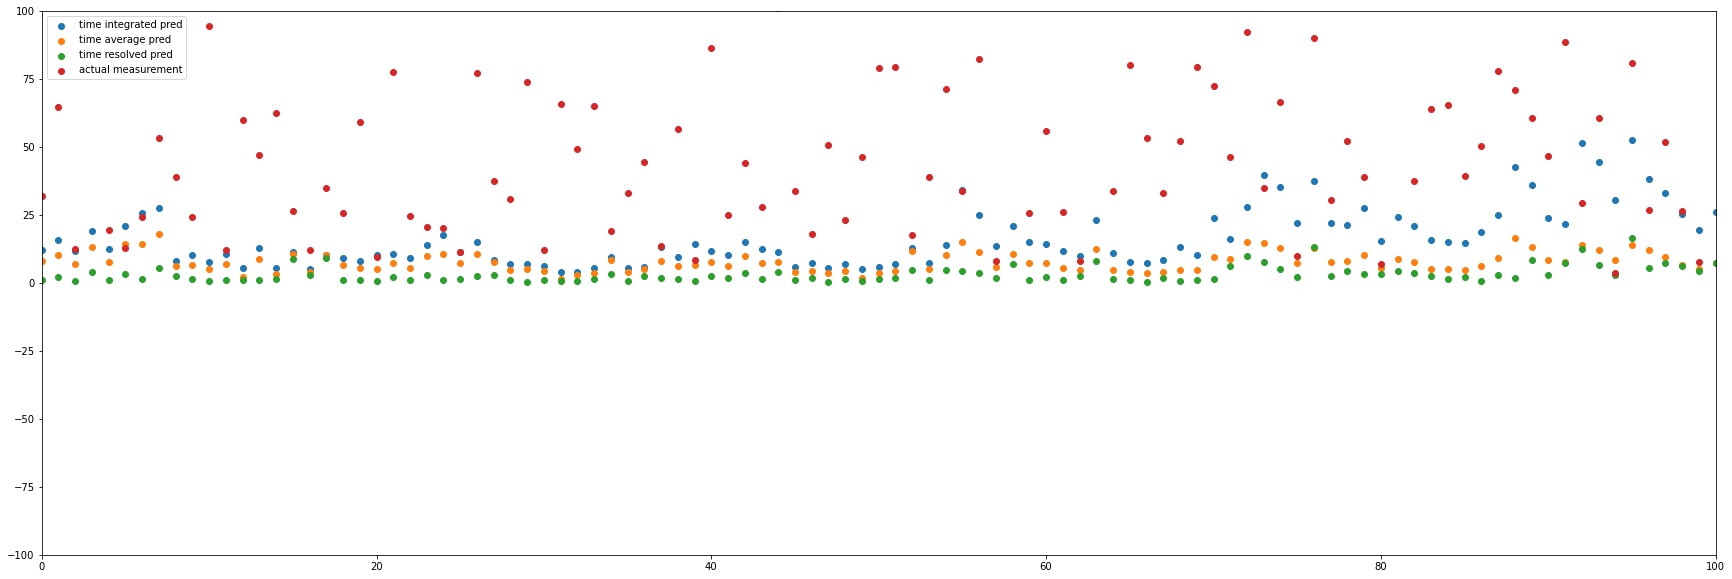

In [22]:
plt.figure(figsize=(30, 10))
plt.scatter(results_df.index, results_df['time_integrated_current_ems'], label='time integrated pred')
plt.scatter(results_df.index, results_df['time_integrated_average_ems'], label='time average pred')
plt.scatter(results_df.index, results_df['time_resolved'], label='time resolved pred')
plt.scatter(results_df.index, results_df['actual_observation'], label='actual measurement')
plt.xlim(0, 100)
plt.ylim(-100, 100)
plt.legend()
# plt.figlegend()
plt.show()


In [23]:
results_df['off_factor_time_resolved'] = results_df['actual_observation']/results_df['time_resolved']

In [ ]:
h = np.array(foot_data['foot'])
y = np.array(foot_data['co2'])-np.array(foot_data['bkg_co2_NOAA'])
x = np.array(ems_data['flx_total'])
h.shape, y, x.shape

In [ ]:
y_pred = np.sum(np.multiply(np.nansum(np.array(h), axis=0), x))
y_pred, case_a_time_integrated_y(h, x, y), y

In [ ]:
ems_data = nc.Dataset(emission_filtered_files[500])

In [ ]:
ems_data['flx_total']

Covariance Matrix

diag_prior = True

# Time resolved

In [18]:
start_time = datetime.datetime(2018, 1, 4, 0, 0)
end_time = datetime.datetime(2018, 1, 5, 0, 0)

In [19]:
emission_filtered_files, emission_files_df = filter_emissions(emission_files, [start_time-datetime.timedelta(hours=71), end_time])
foot_filtered_files, foot_files_df = filter_obs(footprint_files, Inv_lonLim, Inv_latLim, agl_domain='')

In [20]:
emission_files_df.shape

(95, 2)

In [21]:
# filtering footprint_files
domain_foot_files = list(foot_files_df[(foot_files_df['time']>=start_time)&(foot_files_df['time']<end_time)]['file'])

In [22]:
nrow = 481
ncol = 601
m = nrow*ncol

In [23]:
m_start = start_time-datetime.timedelta(hours=71)
m_end = end_time-datetime.timedelta(hours=1)
date_range = pd.date_range(start=m_start, end=m_end, freq='1h')
time_dict = {}
for idx, value in enumerate(date_range):
    time_dict[value] = idx
m_start, m_end

(datetime.datetime(2018, 1, 1, 1, 0), datetime.datetime(2018, 1, 4, 23, 0))

In [24]:
model_error = {
    0:3,
    1:3,
    2:3,
    3:3,
    4:3,
    5:3,
    6:4,
    7:5,
    8:8,
    9:6,
    10:4,
    11:2,
    12:1,
    13:1,
    14:1,
    15:1,
    16:2,
    17:4,
    18:6,
    19:8,
    20:6,
    21:4,
    22:3,
    23:3,
}

In [25]:
global H, Y, So_d, observation_dict
H = np.zeros((len(domain_foot_files), date_range.shape[0]*m), dtype=np.float32)
Y = np.zeros((len(domain_foot_files), 1), dtype=np.float32)
So_d = np.zeros((len(domain_foot_files), 1), dtype=np.float32)
observation_dict = {}

In [26]:
def flatten_2d_column(foot):
    sub_foot = np.zeros((foot.shape[0]*foot.shape[1]))
    for idx in range(foot.shape[1]):
        sub_foot[idx*foot.shape[0]:(idx+1)*foot.shape[0]] = foot[:, idx]
    return sub_foot

In [27]:
observation_dict = {}
def fill_h(idx, foot_file):
    global H, Y, So_d, observation_dict
    [__, timestamp, receptor_lon, receptor_lat, receptor_agl] = foot_file.replace('.nc', '').split("_")
    year = int(timestamp[0:4])
    month = int(timestamp[4:6])
    day = int(timestamp[6:8])
    hour = int(timestamp[8:])
    time_foot = datetime.datetime(year, month, day, hour)
    index = time_dict[time_foot]
    observation_dict[idx] = {
        "time":time_foot,
        "lon":float(receptor_lon),
        "lat":float(receptor_lat),
        "agl":float(receptor_agl)
    }
    # print(H[idx, index*m:(index+1)*m].shape, 481*601)
    
    foot_data = nc.Dataset(foot_file)
    foot = np.array(foot_data['foot'])
    Y[idx, 0] = np.float32(np.array(foot_data['co2'])[0] - np.array(foot_data['bkg_co2_NOAA'])[0])
    obs_error = np.float32(np.array(foot_data['co2_err'])[0])
    bkg_error = np.float32(np.array(foot_data['bkg_err_NOAA'])[0])
    mod_error = model_error[time_foot.hour]
    So_d[idx, 0] = obs_error**2+bkg_error**2+mod_error**2
    # return_foot = np.zeros((1, date_range.shape[0]*m))
    resolved_time_list = date_range[date_range<=time_foot][-foot.shape[0]:]
    for jdx, time_hour in enumerate(resolved_time_list):
        m_index = time_dict[time_hour]
        # print(m_index, time_hour, jdx)
        H[idx, m_index*m:(m_index+1)*m] = flatten_2d_column(foot[jdx, :, :])
    return

def fill_h_parallel():
    # print("filling H ...")
    # H = np.zeros((len(domain_foot_files), date_range.shape[0]*m))
    OUTPUT = Parallel(n_jobs=-1, verbose=10, backend='threading')(delayed(fill_h)(idx, foot_file) for idx, foot_file in enumerate(domain_foot_files))
    # for value in OUTPUT:
    #     index = value[1]
    #     data = value[0]
    #     H[index, :] = data
    # return H
fill_h_parallel()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 185 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 237 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 293 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 372 out of 453 | elaps

In [28]:
def get_len(coords_1, coords_2):
    lat1 = coords_1[0]*np.pi/180
    lon1 = coords_1[1]*np.pi/180
    lat2 = coords_2[0]*np.pi/180
    lon2 = coords_2[1]*np.pi/180
    R = 6371e3
    # a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
    # c = 2 ⋅ atan2( √a, √(1−a) )
    # d = R ⋅ c
    a = np.sin((lat1-lat2)/2)**2 + np.cos(lat1)*np.cos(lat2)*(np.sin((lon1-lon2)/2)**2)
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R*c/1000 #km

In [29]:
nObs = So_d.shape[0]
lowBound = 1e-5
tau_time, tau_space = 1, 2 # hour, km
So = np.zeros((nObs, nObs), dtype=np.float32)
for i in range(So_d.shape[0]):
    So[i,i] = So_d[i,0]
for i in tqdm(range(nObs)):
    time_val_i = observation_dict[i]['time']
    coord_i = (observation_dict[i]['lat'], observation_dict[i]['lon'])
    for j in range(i+1, nObs):
        coord_j = (observation_dict[j]['lat'], observation_dict[j]['lon'])
        time_val = (observation_dict[j]['time']-time_val_i).seconds/3600
        dist_val = get_len(coord_i, coord_j)
        time_decay = np.exp(-abs(time_val)/tau_time)
        dist_decay = np.exp(-abs(dist_val)/tau_space)
        sig_val = time_decay*dist_decay*np.sqrt(So_d[i]*So_d[j])
        if time_decay*dist_decay > lowBound:
            So[i, j] = sig_val
            So[j, i] = sig_val

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [00:01<00:00, 316.68it/s]


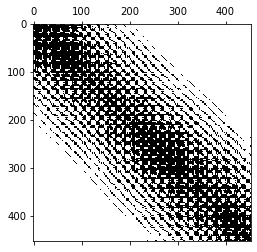

In [30]:
plt.spy(So)

In [31]:
count = 0
for idx in range(H.shape[0]):
    for val in H[375, :]:
        if val!=0:
            count += 1
    break
count

108457

In [32]:
X = np.zeros((date_range.shape[0]*m, 1))
for ems_file in tqdm(emission_filtered_files):
    trimmed_file = ems_file.split("/")[-1].replace("_", "x")
    [_, year, month, day, hour] = trimmed_file.replace('.ncdf', '').split("x")
    year = int(year)
    month = int(month)
    day = int(day)
    hour = int(hour)
    timestamp = datetime.datetime(year, month, day, hour)
    ems_data = np.array(nc.Dataset(ems_file)['flx_total'])
    ems_flattened = flatten_2d_column(ems_data)
    index = time_dict[timestamp]
    X[index*m:(index+1)*m, 0] = ems_flattened

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:03<00:00, 28.59it/s]


In [33]:
diag_prior = True
ems_uncert = 50/100
minUncert = 1.0
x_pri = X
Sa_d = (ems_uncert*x_pri)**2
Sa_d[Sa_d<minUncert**2]=minUncert**2 #diagonal of Sa matrix

In [34]:
row = np.array([i for i in range(X.shape[0])])

In [34]:
Sa = csr_matrix((Sa_d[:, 0], (row, row)), 
                          shape = (X.shape[0], X.shape[0]))

In [35]:
H_sparse = csr_matrix(H)

In [36]:
Y_sparse = csr_matrix(Y)
X_sparse = csr_matrix(X)

In [48]:
H_sparse.shape

(301, 27462695)

In [41]:
So_row = np.array([i for i in range(Y.shape[0])])
So = csr_matrix((So_d[:, 0], (So_row, So_row)), 
                          shape = (Y.shape[0], Y.shape[0]))

In [42]:
So.shape

(301, 301)

In [43]:
mismatch = Y_sparse - csr_matrix.dot(H_sparse, X_sparse)

# KSa* Sa;                   Base.GC.gc() #matrix multiplication K_mat:nxm and Sa:mxm(diagonal values non zero)
#    G        = KSa * transpose(K_mat) + So;  Base.GC.gc()
#    mismatch = G \ mismatch;                 Base.GC.gc()
#    x_dif    = transpose(KSa) * mismatch;    Base.GC.gc()
#    x_hat    = x_pri + x_dif;                Base.GC.gc()

In [44]:
KSa = csr_matrix.dot(H_sparse, Sa)

In [45]:
G = csr_matrix.dot(KSa, H_sparse.T) + So

In [46]:
# mismatch = G\mismatch
mismatch1 = csr_matrix.dot(inv(G), mismatch)

/home/disk/p/nd349/anaconda3/envs/stilt/lib/python3.8/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:322: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/disk/p/nd349/anaconda3/envs/stilt/lib/python3.8/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [47]:
x_dif = csr_matrix.dot(KSa.T, mismatch1)

In [48]:
X_hat = X_sparse + x_dif

In [49]:
X_hat = csr_matrix.toarray(X_hat)

In [65]:
def make_grid_2d_column(X, nrow, ncol):
    X1 = np.zeros((nrow, ncol))
    # import pdb; pdb.set_trace()
    for idx in range(ncol):
        X1[:, idx] = X[idx*nrow:(idx+1)*nrow, 0]
    return X1

In [52]:
X_hat_grid = np.zeros((int(X.shape[0]/m), nrow, ncol))

In [58]:
X_prior = np.zeros((int(X.shape[0]/m), nrow, ncol))
X_prior.shape, X_hat_grid.shape

((95, 481, 601), (95, 481, 601))

In [59]:
for idx in range(X_hat_grid.shape[0]):
    X_hat_grid[idx, :, :] = make_grid_2d_column(X_hat[idx*m:(idx+1)*m], nrow, ncol)
    X_prior[idx, :, :] = make_grid_2d_column(X[idx*m:(idx+1)*m], nrow, ncol)

In [60]:
X_hat_grid.shape, X_prior.shape

((95, 481, 601), (95, 481, 601))

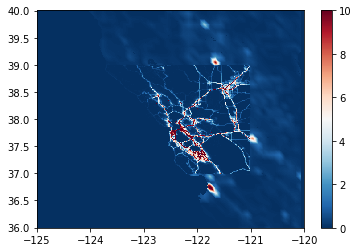

In [70]:
h = plt.pcolor(lons, lats, X_hat_grid[74], vmin=0, vmax=10, cmap='RdBu_r')
plt.colorbar(h)

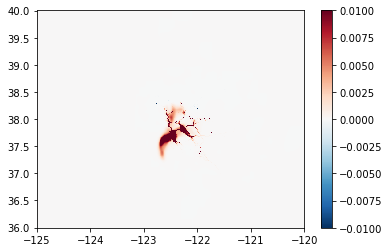

In [69]:
h = plt.pcolor(lons, lats, X_hat_grid[74]-X_prior[74], vmin=-0.01, vmax=0.01, cmap='RdBu_r')
plt.colorbar(h)

In [122]:
np.sum(X_hat_grid[74]), np.sum(X_hat_grid[90])

(110012.06797817477, 127887.15907691667)

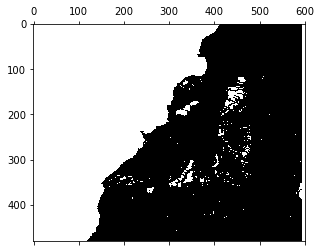

In [71]:
plt.spy(X_hat_grid[90])

In [112]:
X_hat_grid.shape

(95, 481, 601)

# Time Integrated

In [29]:
date_range_integrated = pd.date_range(start=m_start, end=m_end, freq='1h')
emission_filtered_files, emission_files_df = filter_emissions(emission_files, [m_start, end_time])

In [30]:
global H_integrated, Y_integrated, So_d_integrated

In [31]:
time_dict_integrated = {}
for idx, time in enumerate(date_range_integrated):
    time_dict_integrated[time] = idx

In [32]:
H_integrated = np.zeros((len(domain_foot_files), date_range_integrated.shape[0]*m), dtype=np.float32)
Y_integrated = np.zeros((len(domain_foot_files), 1), dtype=np.float32)
So_d_integrated = np.zeros((len(domain_foot_files), 1), dtype=np.float32)

In [33]:
def fill_h_integrated(idx, foot_file):
    global H_integrated, Y_integrated, So_d_integrated
    [__, timestamp, receptor_lon, receptor_lat, receptor_agl] = foot_file.replace('.nc', '').split("_")
    year = int(timestamp[0:4])
    month = int(timestamp[4:6])
    day = int(timestamp[6:8])
    hour = int(timestamp[8:])
    time_foot = datetime.datetime(year, month, day, hour)
    index = time_dict_integrated[time_foot]
    # print(H[idx, index*m:(index+1)*m].shape, 481*601)
    
    foot_data = nc.Dataset(foot_file)
    foot = np.nansum(np.array(foot_data['foot']), axis=0)
    Y_integrated[idx, 0] = np.array(foot_data['co2'])[0] - np.array(foot_data['bkg_co2_NOAA'])[0]
    obs_error = np.array(foot_data['co2_err'])[0]
    bkg_error = np.array(foot_data['bkg_err_NOAA'])[0]
    mod_error = model_error[time_foot.hour]
    So_d_integrated[idx, 0] = obs_error**2+bkg_error**2+mod_error**2
    H_integrated[idx, index*m:(index+1)*m] = flatten_2d_column(foot)

def fill_h_integrated_parallel():
    # print("filling H ...")
    # H = np.zeros((len(domain_foot_files), date_range.shape[0]*m))
    OUTPUT = Parallel(n_jobs=-1, verbose=10, backend='threading')(delayed(fill_h_integrated)(idx, foot_file) for idx, foot_file in enumerate(domain_foot_files))
fill_h_integrated_parallel()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 185 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 237 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 293 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 372 out of 453 | elaps

In [34]:
count = 0
for idx in range(H_integrated.shape[0]):
    for val in H_integrated[25, :]:
        if val!=0:
            count += 1
    break
count

130393

In [37]:
X_integrated = np.zeros((date_range_integrated.shape[0]*m, 1))
for ems_file in tqdm(emission_filtered_files):
    trimmed_file = ems_file.split("/")[-1].replace("_", "x")
    [_, year, month, day, hour] = trimmed_file.replace('.ncdf', '').split("x")
    year = int(year)
    month = int(month)
    day = int(day)
    hour = int(hour)
    timestamp = datetime.datetime(year, month, day, hour)
    ems_data = np.array(nc.Dataset(ems_file)['flx_total'])
    ems_flattened = flatten_2d_column(ems_data)
    index = time_dict_integrated[timestamp]
    X_integrated[index*m:(index+1)*m, 0] = ems_flattened

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:01<00:00, 74.76it/s]


In [38]:
diag_prior = True
ems_uncert = 50/100
minUncert = 1.0
x_pri_integrated = X_integrated
Sa_d_integrated = (ems_uncert*x_pri_integrated)**2
Sa_d_integrated[Sa_d_integrated<minUncert**2]=minUncert**2 #diagonal of Sa matrix

In [39]:
row_integrated = np.array([i for i in range(X_integrated.shape[0])])
Sa_integrated = csr_matrix((Sa_d_integrated[:, 0], (row_integrated, row_integrated)), 
                          shape = (X_integrated.shape[0], X_integrated.shape[0]))

In [40]:
H_integrated_sparse = csr_matrix(H_integrated)
Y_integrated_sparse = csr_matrix(Y_integrated)
X_integrated_sparse = csr_matrix(X_integrated)

In [41]:
So_row_integrated = np.array([i for i in range(Y_integrated.shape[0])])
So_integrated = csr_matrix((So_d_integrated[:, 0], (So_row_integrated, So_row_integrated)), 
                          shape = (Y_integrated.shape[0], Y_integrated.shape[0]))

In [42]:
import time

In [43]:
start = time.time()

mismatch_integrated = Y_integrated_sparse - csr_matrix.dot(H_integrated_sparse, X_integrated_sparse)
KSa_integrated = csr_matrix.dot(H_integrated_sparse, Sa_integrated)
G_integrated = csr_matrix.dot(KSa_integrated, H_integrated_sparse.T) + So_integrated
mismatch1_integrated = csr_matrix.dot(inv(G_integrated), mismatch_integrated)
x_dif_integrated = csr_matrix.dot(KSa_integrated.T, mismatch1_integrated)
X_hat_integrated = X_integrated_sparse + x_dif_integrated

print("time taken:", (time.time()-start))

/home/disk/p/nd349/anaconda3/envs/stilt/lib/python3.8/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:322: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/disk/p/nd349/anaconda3/envs/stilt/lib/python3.8/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


time taken: 3.114410877227783


In [44]:
X_hat_integrated.shape

(27462695, 1)

In [95]:
X_hat_integrated_grid = np.zeros((int(X_integrated.shape[0]/m), nrow, ncol))

In [ ]:
for idx in range(X_hat_integrated_grid.shape[0]):
    X_hat_integrated_grid[idx, :, :] = make_grid_2d_column(X_hat_integrated[idx*m:(idx+1)*m], nrow, ncol)

# Yadav and Michalak

In [37]:
import time

In [109]:
p = 100
q = 100
r = 100
t = 100
n = 500
m1 = p*r;

In [35]:
D = 0 + np.random.randn(p, q)
E = 0 + np.random.randn(r,t)
Q = np.kron(D,E)
# H = np.random.rand(n,m1)

In [36]:
# HQ_DIRECT
start = time.time()
HQ_DIRECT = np.dot(H, Q)
print("HQ DIRECT time:", time.time()-start)

HQ DIRECT time: 0.13344073295593262


In [37]:
# HQHT_DIRECT
start = time.time()
HQHT_DIRECT = np.dot(H, np.dot(Q, H.T))
print("HQHT DIRECT time:", time.time()-start)

HQHT DIRECT time: 0.18117833137512207


In [38]:
# HQ_INDIRECT
start = time.time()
HQ_INDIRECT = np.zeros((n, q*t))
counter = t
for i in range(q):
    temp = (i+1)*t
    HQsum = np.zeros((n, r))
    for j in range(p):
        if D[j, i] != 0 and D[j,i] != 1:
            HQsum +=  H[:,(j)*r:(j+1)*r]*D[j,i]
        elif D[i, j] == 1:
            HQsum += H[:,j*r:(j+1)*r]
    HQ_INDIRECT[:, temp-counter:temp] = np.dot(HQsum, E)
print ("HQ_INDIRECT time:", time.time()-start)

HQ_INDIRECT time: 1.512671709060669


In [174]:
def hq(H, D, E):
    n = H.shape[0]
    p, q = D.shape
    r, t = E.shape
    HQ = np.zeros((n, q*t), dtype=np.float32)
    counter = t
    for i in tqdm(range(q)):
        temp = (i+1)*t
        HQsum = np.zeros((n, r), dtype=np.float32)
        for j in range(p):
            if D[j, i] != 0 and D[j, i] != 1:
                HQsum += H[:, (j)*r:(j+1)*r]*D[j, i]
            elif D[j, i] == 1:
                HQsum += H[:, j*r:(j+1)*r]
        # HQsum = coo_matrix(HQsum)
        HQ[:, temp-counter:temp] = csc_matrix.dot(csc_matrix(HQsum), csc_matrix(E)).toarray()
    return HQ

def hqht(HQ, H, D, E):
    n = H.shape[0]
    p, q = D.shape
    r, t = E.shape
    HQHT = np.zeros((n, n), dtype=np.float32)
    counter = t
    for i in range(q):
        temp = (i+1)*t
        HQHT += np.dot(HQ[:, temp-counter:temp], H[:, (i)*r:(i+1)*r].T)
    return HQHT

In [87]:
HQ = hq(H, Sa_t.toarray(), Sa_xy)

  0%|                                                                                                                          | 0/95 [00:37<?, ?it/s]


KeyboardInterrupt: 

In [106]:
from scipy import stats

In [165]:
D = coo_matrix(sparse.random(p, q,density=0.5,))
E = coo_matrix(sparse.random(r, t,density=0.5,))
H = coo_matrix(sparse.random(n, p*r,density=0.5,))
Q = coo_matrix(np.kron(D.toarray(), E.toarray()))

In [175]:
hq(H.toarray(), D.toarray(), E)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 78.99it/s]


array([[137.92209 , 149.51245 , 126.278694, ..., 149.91931 , 153.38965 ,
         99.83067 ],
       [145.70987 , 152.89586 , 136.54782 , ..., 145.00456 , 157.53809 ,
        113.17639 ],
       [144.41847 , 148.00017 , 136.03836 , ..., 138.76358 , 143.93102 ,
        105.82088 ],
       ...,
       [141.52357 , 141.94861 , 141.37094 , ..., 149.00362 , 150.238   ,
        104.88002 ],
       [146.32506 , 148.14868 , 132.11938 , ..., 141.79012 , 157.15887 ,
        115.64371 ],
       [155.73187 , 163.27332 , 140.50737 , ..., 144.43742 , 142.20847 ,
        112.78688 ]], dtype=float32)

In [176]:
np.dot(H.toarray(), Q.toarray())

array([[137.92208294, 149.51244561, 126.27869617, ..., 149.91930746,
        153.38964905,  99.83067277],
       [145.70986718, 152.89585077, 136.54781739, ..., 145.0045643 ,
        157.53808425, 113.17638971],
       [144.41848122, 148.00017371, 136.03836109, ..., 138.76358018,
        143.93101275, 105.8208789 ],
       ...,
       [141.52358205, 141.94860104, 141.37094508, ..., 149.00361531,
        150.23800886, 104.88001509],
       [146.32505999, 148.14867761, 132.1193922 , ..., 141.79010827,
        157.1588766 , 115.64370716],
       [155.73187425, 163.27331083, 140.50737104, ..., 144.43742167,
        142.20847426, 112.78687923]])

In [168]:
n = H.shape[0]
p, q = Sa_t.shape
r, t = Sa_xy.shape
HQ = csr_matrix(coo_matrix((n, q*t), dtype=np.float32))
Sa_t = coo_matrix(Sa_t)
row = Sa_t.row
col = Sa_t.col
data = Sa_t.data

In [146]:
# Sa_t = csr_matrix
def hq_sparse(H, D, E):
    H = csc_matrix(H).toarray()
    E = csc_matrix(E).toarray()
    row = D.row
    col = D.col
    data = D.data
    counter = t
    HQ = csc_matrix(coo_matrix((n, q*t), dtype=np.float32)).toarray()
    for i in tqdm(col):
        temp = (i+1)*t
        HQsum = csc_matrix(coo_matrix((n, r), dtype=np.float32))
        j = row[i]
        # for j in row:
        if data[i] !=1:
            HQsum += H[:, (j)*r:(j+1)*r]*data[i]
        elif data[i] == 1:
            HQsum += H[:, j*r:(j+1)*r]
        # import pdb; pdb.set_trace()
        HQ[:, temp-counter:temp] = np.dot(HQsum, E)
    return HQ
hq_sparse(H, D, E)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1486.87it/s]


array([[ 4.0742064,  2.4943316,  4.542903 , ...,  4.7789445,  6.008483 ,
         4.453984 ],
       [ 5.1712556,  2.2798665,  5.292713 , ...,  5.411652 ,  8.99013  ,
         8.194243 ],
       [ 4.8650656,  2.7365577,  4.384255 , ...,  7.8261733, 10.81261  ,
         8.471225 ],
       ...,
       [ 5.2380047,  3.0656154,  4.072258 , ...,  5.4828644,  8.231447 ,
         4.042005 ],
       [ 5.9049554,  2.6502352,  5.4747267, ...,  5.615504 ,  7.216447 ,
         6.376104 ],
       [ 4.241249 ,  3.0610693,  2.9993768, ...,  4.3457785,  6.7244453,
         6.2012005]], dtype=float32)

In [151]:
H.shape, Q.shape

((500, 10000), (100, 100))

In [44]:
# HQHT_INDIRECT
start = time.time()
HQHT_INDIRECT = np.zeros((n, n))
counter = t
for i in range(q):
    temp = (i+1)*t
    # HQHT_out = HQHT_out + HQ[:,i*t-t+1:i*t]*H[:,(i-1)*r+1:i*r]'
    HQHT_INDIRECT += np.dot(HQ_INDIRECT[:, temp-counter:temp], H[:, (i)*r:(i+1)*r].T)
print("HQHT_INDIRECT time:", time.time()-start)

HQHT_INDIRECT time: 0.10469818115234375


In [48]:
HQ_INDIRECT

array([[-22.59253421, -28.87949075, -33.51452714, ..., -10.89889572,
        -27.36057758,  -9.15326202],
       [-11.45939375, -57.61746166, -29.95831407, ...,  26.44944432,
        -32.80428826, -21.58777215],
       [-13.77911118, -75.26767807,   5.7101124 , ...,  -9.39800685,
        -14.87791977, -39.44090128],
       ...,
       [ -0.36674996,  16.09313001, -35.58861221, ..., -23.90715003,
         -1.86018547, -48.67666315],
       [-40.69941388,  -7.62591007, -36.33488626, ...,   1.73859306,
        -63.44742   ,  -8.66943072],
       [  6.46357135, -16.09062908, -38.62276925, ..., -18.2378549 ,
         23.84310549, -50.16482336]])

In [50]:
hq_func

array([[-22.592533  , -28.879496  , -33.514523  , ..., -10.898898  ,
        -27.360577  ,  -9.153266  ],
       [-11.459393  , -57.617462  , -29.958313  , ...,  26.449436  ,
        -32.80429   , -21.58777   ],
       [-13.7790985 , -75.26767   ,   5.710125  , ...,  -9.398004  ,
        -14.877923  , -39.440903  ],
       ...,
       [ -0.36675718,  16.093143  , -35.58861   , ..., -23.907148  ,
         -1.8601846 , -48.676662  ],
       [-40.699406  ,  -7.625911  , -36.33489   , ...,   1.7385901 ,
        -63.44742   ,  -8.669434  ],
       [  6.4635754 , -16.090649  , -38.62276   , ..., -18.23785   ,
         23.8431    , -50.16482   ]], dtype=float32)

# Full Covariance Matrix

In [41]:
ems_uncert = 50/100
minUncert = 1.0
tau_day = 1
tau_hr = 5
mVal = minUncert/ems_uncert
lowBound = 1e-5
nEms = int(X.shape[0]/m)

# temporal

In [69]:
def build_temporal(tau_day, tau_hr, x_pri, m):
    nEms = int(x_pri.shape[0]/m)
    nG = m
    tempA = np.zeros((nG))
    tempB = np.zeros((nG))
    Sa_t = np.zeros((nEms, nEms))
    variance_temporal = np.zeros((nEms, 1), dtype=np.float32)
    for i in range(nEms):
        tempA = x_pri[i*m:(i+1)*m]
        variance_temporal[i,0] = np.var(tempA)
        for j in range(i, nEms):
            tempB = x_pri[j*m:(j+1)*m]
            hours_apart = j-i
            days_apart = hours_apart/24
            hours_apart = 12   - abs(12   - np.mod(hours_apart,24))
            temp_hours = np.exp(-abs(hours_apart)/tau_hr)
            temp_days = np.exp(-abs(days_apart)/tau_day)
            # print(temp_hours, temp_days)
            cor = np.corrcoef(tempA[:, 0], tempB[:, 0])[0,1]
            # print(i, j, hours_apart, days_apart, temp_hours, temp_days, tempA.shape, tempB.shape, cor)
            sig_val = cor*temp_hours*temp_days
            if sig_val > lowBound:
                Sa_t[i, j] = sig_val
                Sa_t[j, i] = sig_val
            # else:
            #     Sa_t[i, j] = 10**-7
            #     Sa_t[j, i] = 10**-7
    return Sa_t, variance_temporal # need to convert this to covariance

In [70]:
Sa_t, variance_temporal = build_temporal(tau_day, tau_hr, X, m)

In [ ]:
Sa_t[np.where(Sa_t==0)] = 10**-20

In [71]:
variance_temporal[:,0]

array([227.4433 , 227.00209, 226.63367, 226.23125, 225.8128 , 225.48804,
       225.2675 , 225.17941, 225.16643, 225.22145, 225.4844 , 226.277  ,
       227.51387, 228.63338, 228.41113, 228.01225, 227.96533, 228.13264,
       228.29448, 228.4446 , 228.8383 , 229.2706 , 229.46825, 229.28125,
       227.94637, 226.84204, 226.33755, 226.06613, 225.71867, 225.44702,
       225.27792, 225.1889 , 225.17728, 225.23686, 225.51448, 226.34502,
       227.64053, 228.80203, 228.57677, 228.16289, 228.10481, 228.26842,
       228.42772, 228.57372, 228.97066, 229.40099, 229.59233, 229.39946,
       228.03404, 226.89915, 226.38109, 226.10344, 225.74583, 225.46579,
       225.28094, 225.1905 , 225.17851, 225.23856, 225.51964, 226.3633 ,
       227.68176, 228.86609, 228.63428, 228.21039, 228.1509 , 228.3181 ,
       228.48141, 228.63158, 229.03833, 229.48038, 229.6785 , 229.4833 ,
       228.08922, 226.9313 , 226.40317, 226.1203 , 225.75624, 225.47144,
       225.2926 , 225.19728, 225.18408, 225.2457 , 

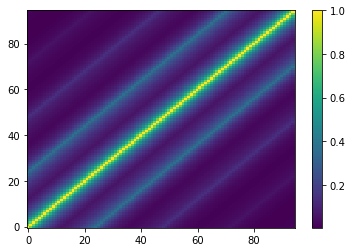

In [58]:
index = [i for i in range(nEms)]
h = plt.pcolor(index, index, Sa_t)
plt.colorbar(h)

In [36]:
plt.plot(Sa_t[0, :])

In [37]:
X.shape

(27462695, 1)

# Spatial

In [39]:
np.array([X[j*m:(j+1)*m, 0][i] for j in range(nEms)]).shape

(95,)

In [38]:
def if_ocean(column):
    if not np.any(column):
        return True
    else:
        return False

tau_len = 5

def get_distance(coords_1, coords_2):
    return geopy.distance.geodesic(coords_1, coords_2).km

def get_len(coords_1, coords_2):
    lat1 = coords_1[0]*np.pi/180
    lon1 = coords_1[1]*np.pi/180
    lat2 = coords_2[0]*np.pi/180
    lon2 = coords_2[1]*np.pi/180
    R = 6371e3
    # a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
    # c = 2 ⋅ atan2( √a, √(1−a) )
    # d = R ⋅ c
    a = np.sin((lat1-lat2)/2)**2 + np.cos(lat1)*np.cos(lat2)*(np.sin((lon1-lon2)/2)**2)
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R*c/1000 #km

# grid_flattened_1 = []
# for lon in lons:
#     for lat in lats:
#         grid_flattened_1.append((lat, lon))

grid_flattened = [(lat, lon) for lon in lons for lat in lats]

# def build_xy(tau_len, x_pri):

nEms = int(X.shape[0]/m)
nG = m
min_distance = 30

emsAll = np.zeros((nEms, nG))
# dist_mat = np.zeros((nG, nG))
# dist_mat = csr_matrix()
ocean = np.zeros((nG))
variance_spatial = np.zeros((nG, 1), dtype=np.float32)
# Sa_xy = np.zeros((nG, nG))

for i in range(nG):
    emsAll[:, i] = np.array([X[j*m:(j+1)*m, 0][i] for j in range(nEms)])
    variance_spatial[i, 0] = np.var(emsAll[:, i])
    if if_ocean(emsAll[:, i]):
        ocean[i] = 1

variance_xy_rows = [i for i in range(nG)]
variance_xy = csr_matrix((variance_spatial[:, 0], (variance_xy_rows, variance_xy_rows)), shape = (nG, nG), dtype=np.float32)

KeyboardInterrupt: 

In [53]:
# import pdb; pdb.set_trace()
print ("Forming spatial covariance")
Sa_xy_file = "data/Sa_xy_corrcoef.pkl"

def load_Sa_xy(file):
	with open(file, 'rb') as open_file:
		Sa_xy = pickle.load(open_file)
	return Sa_xy
Sa_xy = load_Sa_xy(Sa_xy_file)

nEms = int(X.shape[0]/m)
nG = m
emsAll = np.zeros((nEms, nG), dtype=np.float32)
variance_xy = np.zeros((nG, nG), dtype=np.float32)
for i in tqdm(range(nG)):
    emsAll[:, i] = np.array([X[j*m:(j+1)*m, 0][i] for j in range(nEms)])
    variance_xy[i, i] = np.var(emsAll[:, i])


# Sa_xy = np.sqrt(self.fsigma)*(csr_matrix.dot(csr_matrix.sqrt(variance_xy), csr_matrix.dot(Sa_xy), csr_matrix.sqrt(variance_xy)))

Forming spatial covariance


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 289081/289081 [00:16<00:00, 17369.71it/s]


In [54]:
variance_xy = csr_matrix(variance_xy)
variance_xy_sqrt = csr_matrix.sqrt(variance_xy)

Loading Sa_xy

In [46]:
with open("data/Sa_xy_corrcoef.pkl", "rb") as file:
    Sa_xy = pickle.load(file)

In [229]:
idx = (np.abs(lats - 37.943)).argmin()
jdx = (np.abs(lons - -122.347)).argmin()
print(idx, jdx)

233 318


In [230]:
index = jdx*481+idx
index

153191

In [231]:
cov_array = Sa_xy[index, :].toarray().reshape(481, 601, order='F')

In [232]:
cov_array.shape

(481, 601)

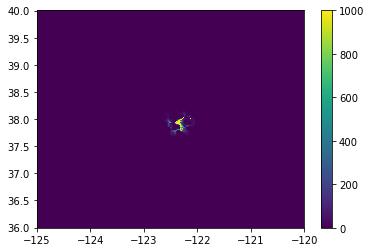

In [235]:
h = plt.pcolor(lons, lats, cov_array, vmin=0, vmax=1000)
plt.colorbar(h)

In [ ]:
144420, 202260

In [78]:
a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

In [116]:
def getUSCoastLine():
    ''' Return US coastline data '''
    # https://www.dropbox.com/s/2ko30nyprpd8dmt/NOS80k.csv
    nos_df = pd.read_csv("../../data/NOS80k.csv", names=["lon", "lat"])
    for idx in range(nos_df.shape[0]):
        if nos_df['lon'][idx] <=-9999:
            nos_df['lon'][idx] = np.nan
            nos_df['lat'][idx] = np.nan
    return nos_df
nos_df = getUSCoastLine()

In [87]:
a.reshape(9, 1, order='F').reshape(3, 3, order='F')

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [221]:
for index in tqdm(np.arange(144420, 202260, 1000)):
    cov_array = Sa_xy[index, :].toarray().reshape(481, 601, order='F')
    h = plt.pcolor(lons, lats, cov_array, vmin=0, vmax=1)
    plt.colorbar(h)
    h2 = plt.plot(nos_df['lon'], nos_df['lat'], 'k',)
    plt.xlim(-125, -120)
    plt.ylim(36, 40)
    plt.title(f"Spatial Covariance Matrix column:{index}")
    # plt.show()
    plt.savefig(f"plots/spatial_cov/spatial_cov_matrix_column{index}.png")
    plt.close()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [02:05<00:00,  2.16s/it]


In [222]:
import imageio, os, re

def getGIF_singleLoc(gifname, saveLocation='', drop=False):
    ''' Create gif for the footprints '''
    filenames = get_files(saveLocation, ".png")
    with imageio.get_writer(gifname, mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            for idx in range(5):
                writer.append_data(image)
    print(f'GIF: {gifname} has been saved!')
    if drop:
        # Remove files
        for filename in set(filenames):
            os.remove(filename)
    return

In [223]:
getGIF_singleLoc("plots/spatial_cov.gif", saveLocation="plots/spatial_cov/")

GIF: plots/spatial_cov.gif has been saved!


In [224]:
nG

289081

In [228]:
np.zeros((nG, nG), dtype=np.float32)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Python Inversion Module test

In [2]:
from diagPrior.time_resolved_diag_prior import InversionDiagPrior
from Utils.getData import *
from config import *
invert = InversionDiagPrior(H, X, Y, So_d)

In [31]:
count = 0
for idx in range(H.shape[0]):
    for val in H[250, :]:
        if val!=0:
            count += 1
    break
count

300313

In [7]:
H.shape

(453, 27462695)

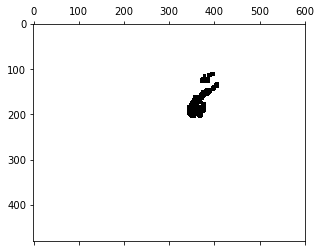

In [74]:
index = 0
for j in range(69, date_range.shape[0]):
    value = H[index,j*m:(j+1)*m].reshape(nrow, ncol, order='F')
    plt.spy(value)
    break

In [36]:
H

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# FullCovariance Computation

In [ ]:
KSa = hq(H_sparse, csr_matrix(Sa_t), csr_matrix(Sa_xy))

In [1]:
from Utils.getData import *
from config import *
import matplotlib.pyplot as plt

sys.argv: ['-f', '/home/disk/p/nd349/.local/share/jupyter/runtime/kernel-41968e17-4e29-4a3f-a34f-a57495a5ffdb.json']
job field is empty: ['-f', '/home/disk/p/nd349/.local/share/jupyter/runtime/kernel-41968e17-4e29-4a3f-a34f-a57495a5ffdb.json']
Location: 
Mode: integrated_decayed
Device: cpu
Start date: 2018-01-04 00:00:00
End date: 2018-01-05 00:00:00
Inversion grid: ([-123.1, -121.8], [37.35, 38.4])
Posterior solutions output location: /home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/posterior2018-01-02_12:00:00_2018-01-06_11:00:00_integrated_decayed_cpu.nc
Output directory: /home/disk/hermes/nd349/data/inversion/integrated_decayed_BEACON/

Reading observation data ....


0it [00:00, ?it/s]

Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed


128it [00:03, 41.15it/s]

Loop: integrated_decayed
Loop: Loop: integrated_decayed
integrated_decayedLoop: integrated_decayed

Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayedLoop: integrated_decayed

Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop:Loop: integrated_decayed
 integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed
Loop: integrated_decayed



KeyboardInterrupt



In [2]:
H.shape[1]/m, H_check.shape[1]/m

(96.0, 96.0)

In [3]:
count = 0
for idx in range(H.shape[0]):
    count = 0
    for jdx in range(int(H.shape[1]/m)):
        value = H[idx, jdx*m:(jdx+1)*m]
        if np.sum(value)>0:
            count += 1
    print(idx, count)
print(count)

0 37
1 37
2 37
3 37
4 37
5 37
6 37
7 37
8 37
9 37
10 37
11 37
12 37
13 37
14 37
15 37
16 37
17 37
18 37
19 37
20 37
21 37
22 37
23 37
24 37
25 37
26 37
27 37
28 37
29 37
30 37
31 37
32 37
33 37
34 37
35 37
36 37
37 37
38 37
39 37
40 37
41 37
42 37
43 37
44 37
45 37
46 37
47 37
48 37
49 37
50 37
51 37
52 37
53 37
54 37
55 37
56 37
57 37
58 37
59 37
60 37
61 37
62 37
63 37
64 37
65 37
66 37
67 37
68 37
69 37
70 37
71 37
72 37
73 37
74 37
75 37
76 37
77 37
78 37
79 37
80 37
81 37
82 37
83 37
84 37
85 37
86 37
87 37
88 37
89 37
90 37
91 37
92 37
93 37
94 37
95 37
96 37
97 37
98 37
99 37
100 37
101 37
102 37
103 37
104 37
105 37
106 37
107 37
108 37
109 37
110 37
111 37
112 37
113 37
114 37
115 37
116 37
117 37
118 37
119 37
120 37
121 37
122 37
123 37
124 37
125 37
126 37
127 37
128 37
129 37
130 37
131 37
132 37
133 37
134 37
135 37
136 37
137 37
138 37
139 37
140 37
141 37
142 37
143 37
144 37
145 37
146 37
147 37
148 37
149 37
150 37
151 37
152 37
153 37
154 37
155 37
156 37
157 37
158 

In [4]:
index = 0
np.sum(H[index, :], axis=0)

3.0997944

In [11]:
sum([np.sum(H[index, key*m:(key+1)*m], axis=0) for key in range(37)])

3.099794387794829

In [21]:
np.sum(H_check[index, 36*m:37*m])/16, np.sum(H[index, 33*m:34*m])

(0.19373714923858643, 0.19373715)

In [22]:
from fullCovariance.InversionFullCovariance import InversionFullPrior

In [23]:
inversion = InversionFullPrior(H, X, Y, So)

Forming sparse matrices ....


100%|███████████████████████████████████████████████| 96/96 [00:08<00:00, 11.01it/s]


Forming spatial covariance


100%|████████████████████████████████████| 289081/289081 [00:16<00:00, 17179.85it/s]


Converting variance into sparse
Computing covariance matrix


In [ ]:
X_hat = inversion.invert()

Inversion is starting .....
Size of H: (453, 27751776)
Size of X prior: (27751776, 1)
Size of Y: (453, 1)
Size of So: (453, 453)
Size of Sa_t: (96, 96)
Size of Sa_xy: (289081, 289081)
computing mismatch ....
computing HQ ....


 12%|█████▉                                         | 12/96 [07:27<51:58, 37.12s/it]

In [26]:
type(X_hat)

numpy.matrix

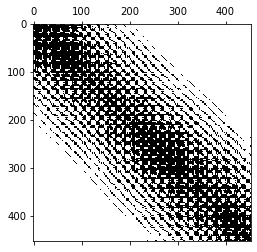

In [60]:
plt.spy(So.toarray())

In [94]:
def flatten_2d_column(foot):
    sub_foot = np.zeros((foot.shape[0]*foot.shape[1]))
    for idx in range(foot.shape[1]):
        sub_foot[idx*foot.shape[0]:(idx+1)*foot.shape[0]] = foot[:, idx]
    return sub_foot

def make_grid_2d_column(X, nrow, ncol):
    X1 = np.zeros((nrow, ncol))
    import pdb; pdb.set_trace()
    for idx in range(ncol):
        X1[:, idx] = X[idx*nrow:(idx+1)*nrow, 0]
    return X1

In [72]:
a = np.array([[1, 2, 3],
             [4, 5, 6],
             [7, 8, 9]])
flatten_2d_column(a)

array([1., 4., 7., 2., 5., 8., 3., 6., 9.])

In [136]:
X_hat.shape[0]/m, solution_date_range.shape

(24.0, (24,))

In [82]:
flatten_2d_column(a).reshape(3, 3, order='F')

array([[1., 2., 3.],
       [4., 5., 6.],
       [7., 8., 9.]])

In [142]:
location = 'BEACON'
output_directory = "/home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/"

In [149]:
def save_solution(X_hat):
    # X_hat = self.X_hat
    X_hat_grid = np.zeros((int(X_hat.shape[0]/m), nrow, ncol))
    for idx in range(X_hat_grid.shape[0]):
        # X_hat_grid[idx, :, :] = make_grid_2d_column(X_hat[idx*m:(idx+1)*m, 0], nrow, ncol)
        X_hat_grid[idx, :, :] = X_hat[idx*m:(idx+1)*m, 0].reshape(nrow, ncol, order='F')
    solution_date_range = pd.date_range(start=start_time, end=end_time-datetime.timedelta(hours=1), freq='1h')
    for idx, timestamp in tqdm(enumerate(solution_date_range)):
        year = str(timestamp.year)
        month = str(timestamp.month)
        day = str(timestamp.day)
        hour = str(timestamp.hour)
        if len(month)==1:
            month = '0'+month
        if len(day) == 1:
            day = '0'+day
        if len(hour) == 1:
            hour = '0'+hour
        timestamp = f"{year}{month}{day}{hour}"
        file = f"{output_directory}{location}_{year}x{month}x{day}x{hour}.ncdf"
        flux = X_hat_grid[idx, :, :]
        print(file)
        
    
        out_nc = nc.Dataset(file, "w", format='NETCDF4')
        out_nc.createDimension("lat", nrow)
        out_nc.createDimension("lon", ncol)
        out_nc.createDimension("info", 1)
        lat = out_nc.createVariable("lat", "f8", ("lat",))
        lon = out_nc.createVariable("lon", "f8", ("lon",))

        lat[:] = lats
        lon[:] = lons
        # out_nc.createVariable("timestamp", "f8", ("info"))[:] = int(timestamp)
        # timesteps[:] = out_nc.stringtochar(np.array([message], 'S'))
        soln = out_nc.createVariable("flux", "f8", ("lat", "lon"))
        soln[:,:] = flux
        out_nc.close()

save_solution(X_hat)

0it [00:00, ?it/s]

/home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/BEACON_2018x01x04x00.ncdf


1it [00:00,  2.01it/s]

/home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/BEACON_2018x01x04x01.ncdf


4it [00:00,  6.29it/s]

/home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/BEACON_2018x01x04x02.ncdf
/home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/BEACON_2018x01x04x03.ncdf
/home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/BEACON_2018x01x04x04.ncdf
/home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/BEACON_2018x01x04x05.ncdf
/home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/BEACON_2018x01x04x06.ncdf


10it [00:01, 14.94it/s]

/home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/BEACON_2018x01x04x07.ncdf
/home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/BEACON_2018x01x04x08.ncdf
/home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/BEACON_2018x01x04x09.ncdf
/home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/BEACON_2018x01x04x10.ncdf
/home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/BEACON_2018x01x04x11.ncdf
/home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/BEACON_2018x01x04x12.ncdf


16it [00:01, 19.26it/s]

/home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/BEACON_2018x01x04x13.ncdf
/home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/BEACON_2018x01x04x14.ncdf
/home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/BEACON_2018x01x04x15.ncdf
/home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/BEACON_2018x01x04x16.ncdf
/home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/BEACON_2018x01x04x17.ncdf


19it [00:01, 17.52it/s]

/home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/BEACON_2018x01x04x18.ncdf
/home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/BEACON_2018x01x04x19.ncdf
/home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/BEACON_2018x01x04x20.ncdf
/home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/BEACON_2018x01x04x21.ncdf


24it [00:01, 13.81it/s]

/home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/BEACON_2018x01x04x22.ncdf
/home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python/data/inversion/BEACON_2018x01x04x23.ncdf


In [179]:
data = nc.Dataset("/home/disk/hermes/nd349/data/inversion/BEACON/BEACON_2018x01x04x05.ncdf")
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): lat(481), lon(601), info(1)
    variables(dimensions): float64 lat(lat), float64 lon(lon), float64 flux(lat, lon)
    groups: 

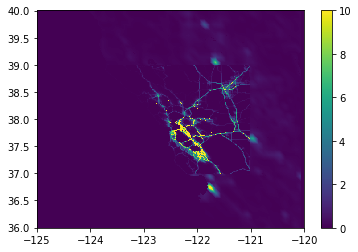

In [181]:
h = plt.pcolor(np.array(data['lon']), np.array(data['lat']), np.array(data['flux']), vmin=0, vmax=10)
plt.colorbar(h)

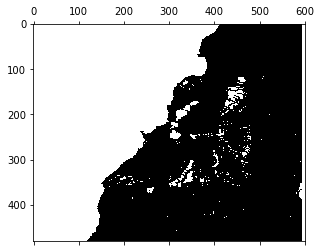

In [162]:
plt.spy(np.array(data['flux']))

In [129]:
# nc.stringtochar(np.array([str(element) for element in solution_date_range], 'S19'))

array([[b'2', b'0', b'1', b'8', b'-', b'0', b'1', b'-', b'0', b'4', b' ',
        b'0', b'0', b':', b'0', b'0', b':', b'0', b'0'],
       [b'2', b'0', b'1', b'8', b'-', b'0', b'1', b'-', b'0', b'4', b' ',
        b'0', b'1', b':', b'0', b'0', b':', b'0', b'0'],
       [b'2', b'0', b'1', b'8', b'-', b'0', b'1', b'-', b'0', b'4', b' ',
        b'0', b'2', b':', b'0', b'0', b':', b'0', b'0'],
       [b'2', b'0', b'1', b'8', b'-', b'0', b'1', b'-', b'0', b'4', b' ',
        b'0', b'3', b':', b'0', b'0', b':', b'0', b'0'],
       [b'2', b'0', b'1', b'8', b'-', b'0', b'1', b'-', b'0', b'4', b' ',
        b'0', b'4', b':', b'0', b'0', b':', b'0', b'0'],
       [b'2', b'0', b'1', b'8', b'-', b'0', b'1', b'-', b'0', b'4', b' ',
        b'0', b'5', b':', b'0', b'0', b':', b'0', b'0'],
       [b'2', b'0', b'1', b'8', b'-', b'0', b'1', b'-', b'0', b'4', b' ',
        b'0', b'6', b':', b'0', b'0', b':', b'0', b'0'],
       [b'2', b'0', b'1', b'8', b'-', b'0', b'1', b'-', b'0', b'4', b' ',
        b

In [135]:
solution_date_range = pd.date_range(start=start_time, end=end_time-datetime.timedelta(hours=1), freq='1h')

In [ ]:
data = nc.Dataset

In [2]:
import datetime # ; import time
import numpy as np
import pandas as pd


In [26]:
start = datetime.datetime(2018, 1, 4, 0, 0)
end = datetime.datetime(2018, 1, 10, 0, 0)
hours_interval = 24 # hours
difference = (end-start).total_seconds()/3600 # hours

In [36]:
iteration = int(difference/hours_interval)

for idx in range(iteration):
    print(start+datetime.timedelta(hours=hours_interval*(idx)))
    print(start+datetime.timedelta(hours=hours_interval*(idx+1)))
    print(idx)

2018-01-04 00:00:00
2018-01-05 00:00:00
0
2018-01-05 00:00:00
2018-01-06 00:00:00
1
2018-01-06 00:00:00
2018-01-07 00:00:00
2
2018-01-07 00:00:00
2018-01-08 00:00:00
3
2018-01-08 00:00:00
2018-01-09 00:00:00
4
2018-01-09 00:00:00
2018-01-10 00:00:00
5


# Slurm Job Script

In [200]:
start = '2018010400'
end = '2018010500'
location = 'BEACON'
jobname = f'BEACON_{start}'

with open('job.sh', 'w') as file:
    file.writelines("#!/bin/bash\n")
    file.writelines("\n")
    file.writelines("#SBATCH\n")
    file.writelines(f"#SBATCH --job-name={jobname}\n")
    file.writelines("#SBATCH -N 1      # nodes requested\n")
    file.writelines("#SBATCH -n 1      # tasks requested\n")
    file.writelines("#SBATCH -c 32      # cores requested\n")
    file.writelines("#SBATCH --mem=102400  # memory in Mb\n")
    file.writelines("#SBATCH -o slurm_output_%j.out  # send stdout to outfile\n")
    file.writelines("#SBATCH -e slurm_errfile_%j.out  # send stderr to errfile\n")
    file.writelines("#SBATCH -t 96:00:00  # time requested in hour:minute:second\n")
    file.writelines("\n\n\n")
    
    file.writelines("cd /home/disk/p/nd349/nikhil.dadheech/pointSources/Inversion/BEACON_Inv_python\n")
    file.writelines("source /home/disk/p/nd349/anaconda3/etc/profile.d/conda.sh\n")
    file.writelines("\n\n\n")
    file.writelines("conda activate stilt\n")
    file.writelines("time python template.py $1 $2 $3")
file.close()

In [9]:
directory = "/home/disk/hermes/nd349/data/inversion/integrated_decayed_BEACON"

In [10]:
files = get_files(directory, extension='ncdf')
files.sort()

In [ ]:
missed_dates = ['20200305','20200306', '20200310', '20200312', '20200408', '20200410', '20200411']

In [12]:
timeseries = []
for file in files:
    term = file.replace(".ncdf", "").split("_")[-1]
    date = term.replace("x", "")[:-2]
    if date not in timeseries:
        timeseries.append(date)
timeseries

['20200202',
 '20200203',
 '20200204',
 '20200205',
 '20200206',
 '20200207',
 '20200208',
 '20200209',
 '20200210',
 '20200211',
 '20200212',
 '20200213',
 '20200214',
 '20200215',
 '20200216',
 '20200217',
 '20200218',
 '20200219',
 '20200220',
 '20200221',
 '20200222',
 '20200223',
 '20200224',
 '20200225',
 '20200226',
 '20200227',
 '20200228',
 '20200229',
 '20200301',
 '20200302',
 '20200303',
 '20200304',
 '20200307',
 '20200308',
 '20200309',
 '20200311',
 '20200313',
 '20200314',
 '20200322',
 '20200323',
 '20200324',
 '20200325',
 '20200326',
 '20200327',
 '20200328',
 '20200329',
 '20200330',
 '20200331',
 '20200401',
 '20200402',
 '20200403',
 '20200404',
 '20200405',
 '20200406',
 '20200407',
 '20200409',
 '20200411',
 '20200412',
 '20200413',
 '20200414',
 '20200415',
 '20200416',
 '20200417',
 '20200418',
 '20200419',
 '20200420',
 '20200421',
 '20200422',
 '20200423',
 '20200424',
 '20200425',
 '20200426',
 '20200427',
 '20200428',
 '20200429',
 '20200430',
 '20200501',

# integrated decayed weights H

In [27]:
x = 1
r = 1/np.e
n = 36
a = x*(1-r)/(1-r**n)
weight_list = []
weight_list.append(a)
term = a
for idx in range(n-1):
    term = term*r
    weight_list.append(term)

In [26]:
1/np.e

0.36787944117144233

In [28]:
weight_list

[0.6321205588285578,
 0.2325441579348297,
 0.08554821486874878,
 0.03147142947912977,
 0.011577691889648717,
 0.00425919482241911,
 0.0015668702111118428,
 0.0005764193376520046,
 0.00021205282381583237,
 7.800987432419473e-05,
 2.8698228972239205e-05,
 1.0557488436917455e-05,
 3.883882946347158e-06,
 1.4288006878774874e-06,
 5.256263986017425e-07,
 1.9336714578256684e-07,
 7.113579753140751e-08,
 2.6169397443139062e-08,
 9.62718330717537e-09,
 3.541642815098713e-09,
 1.3028975796473685e-09,
 4.793092335042987e-10,
 1.7632801296987378e-10,
 6.4867450874228e-11,
 2.3863401577826985e-11,
 8.778854836900707e-12,
 3.2295602115242455e-12,
 1.1880888058450646e-12,
 4.370734459563286e-13,
 1.6079033504929077e-13,
 5.915145860370207e-14,
 2.176060553560562e-14,
 8.00527940399079e-15,
 2.944977713561389e-15,
 1.0833967555273159e-15,
 3.985593929903427e-16]

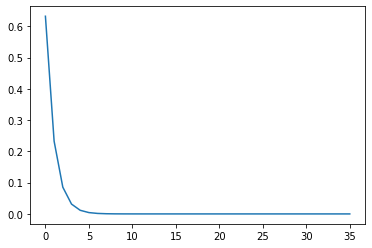

In [29]:
axis = [i for i in range(len(weight_list))]
plt.plot(axis, weight_list)

In [30]:
sum(weight_list)

0.9999999999999999